<a href="https://colab.research.google.com/github/NataliaKor/tutorial/blob/main/tutorial-ML-for-GWPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Machine Learning for Gravitational Wave Parameter Estimation

### Stephen Green *stephen.green2@nottingham.ac.uk* and Natalia Korsakova *korsakova@apc.in2p3.fr*

---

In this tutorial we will build a simple **parameter estimation** neural network:
* **Training data:** FastGB waveforms, parametrized only by initial frequency (f0) and amplitude; noise added during training
* **Posterior model 1:** Gaussian with learnable (diagonal) covariance matrix
* **Posterior model 2:** Learned with the Normalising Flow. Real NVP implementation

### Exercises
1. Add inclination in addition to f0 and amplitude
2. Extend the Gaussian distribution to include general covariance
3. Make a PP plot

## Imports

In [1]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# pytorch imports
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch import distributions

from sklearn import datasets

In [3]:
import matplotlib.pyplot as plt
import corner
import numpy as np
if torch.cuda.is_available():
   import cupy as cp
else:
   import numpy as cp
   

In [4]:
!git clone https://github.com/NataliaKor/GBGPU.git

fatal: destination path 'GBGPU' already exists and is not an empty directory.


In [5]:
from GBGPU.gbgpu.gbgpu import GBGPU
from GBGPU.gbgpu.noisemodel import AnalyticNoise 

## Training data

Generate a training set that (for simplicity) samples only over amplitudes and frequencies. Generate frequency-domain waveforms using FastGB. We will add noise during training.

**Exercise:** Add more parameters. Start with the inclination. Inclination lyes in $[0, 2\pi]$ and is usually sampled in cosine.

In [6]:
# Initialise class for waveform generation

gb = GBGPU(use_gpu=True)


In [7]:
num_samples = 10000  # size of the training set

# Ranges for frequency
f0_min = 0.010062
f0_max = 0.010084

# Ranges for log amplitude
amp_min = -23.
amp_max = -21.

# Sample frequency
f0 = np.random.uniform(f0_min, f0_max, num_samples)

# Sample amplitude
amp = 10**np.random.uniform(amp_min, amp_max, num_samples)



In [8]:
# Fixed parameters

fdot = np.repeat(1.79e-15, num_samples)
lam  = np.repeat(4.36, num_samples)
beta = np.repeat(2.18, num_samples)
iota = np.repeat(0.67, num_samples)
phi0 = np.repeat(5.48, num_samples)
psi  = np.repeat(0.43, num_samples)



In [9]:
# Waveform settings

Tobs = 31536000.0
dt = 15.0
df = 1./Tobs

#print('fvec_min = ', f0_min - df*64)
#print('fvec_max = ', f0_max + df*64)

fvec_min = 0.010059
fvec_max = 0.0100861

# Put the waveform in the common frequency band 
k_min = np.round(fvec_min/df).astype(int)
k_max = np.round(fvec_max/df).astype(int)
num = k_max - k_min

freqs = (np.arange(num) + k_min)*df


In [10]:
# Noise PSD

noise = AnalyticNoise(freqs)
psdA, psdE = noise.psd(option="A"), noise.psd(option="E")

asdA = np.sqrt(psdA)
asdE = np.sqrt(psdE)

In [19]:
# Generate training waveforms
N_points = 128

params = np.array([amp, f0, fdot, 0.0, -phi0, iota, psi, lam, beta])
gb.run_wave(*params, N = N_points, dt = dt, T = Tobs, oversample = 1)#oversample=2)
    
if torch.cuda.is_available():
    i_start = (gb.start_inds.get() - k_min).astype(np.int32)
    i_end = (gb.start_inds.get() - k_min + gb.N).astype(np.int32)
else:
    i_start = (gb.start_inds - k_min).astype(np.int32)
    i_end = (gb.start_inds - k_min + gb.N).astype(np.int32)

A_out = cp.zeros((num_samples, num), dtype=cp.complex128)
E_out = cp.zeros((num_samples, num), dtype=cp.complex128)

for i in range(num_samples):
    A_out[i, i_start[i] : i_end[i]] = gb.A[i]
    E_out[i, i_start[i] : i_end[i]] =  gb.E[i]

# Whiten waveforms 
Awf = A_out * cp.sqrt(4.0 * df)* dt/cp.array(asdA)
Ewf = E_out * cp.sqrt(4.0 * df)* dt/cp.array(asdE)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


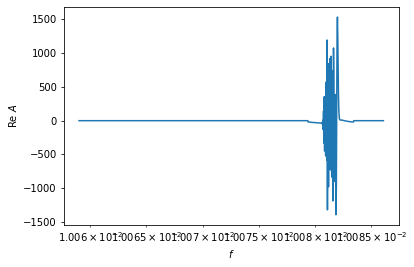

In [21]:
# Sample waveform
if torch.cuda.is_available():
  Awf_plot = Awf[0].real.get()
else:
  Awf_plot = Awf[0].real

plt.plot(freqs, Awf_plot)
plt.xscale('log')
plt.xlabel('$f$')
plt.ylabel('Re $A$')

plt.show()

### Package into a pytorch Dataset

In [23]:
# Combine parameters into array

parameters = np.stack((f0, amp), axis=1).astype(np.float32)

In [24]:
# For best training, parameters should be standardized (zero mean, unit variance across the training set)

parameters_mean = np.mean(parameters, axis=0)
parameters_std = np.std(parameters, axis=0)

parameters_standardized = (parameters - parameters_mean) / parameters_std

In [26]:
# Waveforms
# Repackage real and imaginary parts
# Use only A, but can add E 

#norm_for_all = cp.amax(cp.c_[Awf.real, Awf.imag, Ewf.real, Ewf.imag])
norm_for_all = cp.amax(cp.c_[Awf.real, Awf.imag])
waveforms = cp.c_[Awf.real.squeeze(), Awf.imag.squeeze()].astype(cp.float32)
#                 Ewf.real.squeeze(), Ewf.imag.squeeze()].astype(cp.float32)



In [27]:
class WaveformDataset(Dataset):
    
    def __init__(self, parameters, waveforms, norm_for_all):
        self.parameters = parameters
        self.waveforms = waveforms

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        params = self.parameters[idx]
        signal = self.waveforms[idx]
        
        # Add unit normal noise to the signal
        noise = cp.random.normal(size = signal.shape).astype(cp.float32)
        data = ((signal + noise)/norm_for_all).astype(cp.float32)
        
        return torch.tensor(data), torch.tensor(params)

In [28]:
waveform_dataset = WaveformDataset(parameters_standardized, waveforms, norm_for_all)

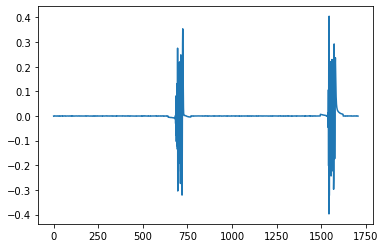

In [29]:
# We can sample from the WaveformDataset. This gives us pairs of data and parameters, different noise realizations each time.

x, y = waveform_dataset[0]
plt.plot(x)

## Posterior Model

In [30]:
# Neural networks are constructed by subclassing nn.Module
#
# This has to implement an __init__() and forward() method

class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.ReLU()):
        super(NeuralNetwork, self).__init__()
        
        # Hidden layers
        hidden_net_list = []
        hidden_net_list.append(
            nn.Linear(input_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            hidden_net_list.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        self.hidden_net_list = nn.ModuleList(hidden_net_list)
        
        # Output layers
        self.output_mean = nn.Linear(hidden_dims[-1], output_dim)
        self.output_log_sigma = nn.Linear(hidden_dims[-1], output_dim)
        
        # Activation function
        self.activation = activation
        
    def forward(self, x):
        """Pass x through all the layers of the network and return the Gaussian distribution"""
        
        h = x
        for layer in self.hidden_net_list:
            h = self.activation(layer(h))

        # Output layer defines a Gaussian
        mean = self.output_mean(h)
        log_sigma = self.output_log_sigma(h)
        sigma = torch.exp(log_sigma)
        
        # Create the Gaussian distribution
        dist = torch.distributions.MultivariateNormal(loc=mean, scale_tril=torch.diag_embed(sigma))
        
        return dist

In [31]:
input_dim = waveforms.shape[-1]
output_dim = parameters.shape[-1]
hidden_dims = [512, 256, 128, 64, 32]

model = NeuralNetwork(input_dim, hidden_dims, output_dim)

In [32]:
print(model)

NeuralNetwork(
  (hidden_net_list): ModuleList(
    (0): Linear(in_features=1708, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_mean): Linear(in_features=32, out_features=2, bias=True)
  (output_log_sigma): Linear(in_features=32, out_features=2, bias=True)
  (activation): ReLU()
)


## Training

In [33]:
# Split the dataset into training and test sets

train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [34]:
# The DataLoaders iterate over samples, returning torch tensors containing a batch of data

train_features, train_labels = next(iter(train_dataloader))

In [35]:
train_features

tensor([[ 3.1749e-04,  2.1045e-04,  9.3248e-05,  ..., -4.4641e-06,
          4.1744e-04, -1.4463e-04],
        [-2.7077e-04,  1.6493e-05, -2.2126e-04,  ...,  3.0808e-05,
          1.8357e-04,  8.4682e-05],
        [ 4.1201e-05,  2.5008e-04, -1.5429e-04,  ...,  1.2346e-04,
         -8.2103e-05, -5.9305e-05],
        ...,
        [ 1.8160e-04,  1.7493e-04, -2.0279e-05,  ..., -1.2792e-04,
          2.3524e-04, -2.3279e-04],
        [-3.5389e-04,  3.2297e-05, -2.4378e-06,  ...,  1.8528e-04,
          1.1683e-05,  2.2925e-04],
        [-2.2780e-04,  4.2320e-05, -5.6576e-04,  ...,  2.8112e-04,
         -6.5967e-05, -3.8589e-04]])

In [36]:
train_features.shape

torch.Size([64, 1708])

In [37]:
# We use the Adam optimizer.

#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=1e-4)

In [38]:
# Training and test loops

def train_loop(dataloader, model, optimizer):
 
    size = len(dataloader.dataset)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute negative log probability loss
        dist = model(X)        
        loss = - dist.log_prob(y)
        
        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")
            
    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss
            
              
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            dist = model(X)
            loss = - dist.log_prob(y)
            test_loss += loss.sum()

    test_loss /= size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [39]:
epochs = 20
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, model, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, model)
    test_history.append(loss)
print("Done!")

Epoch 1
-------------------------------
Loss: 2.905574  [    0/ 8000 samples]
Loss: 2.904494  [ 3200/ 8000 samples]
Loss: 2.826703  [ 6400/ 8000 samples]
Average loss: 2.8504
Test loss: 2.776688 

Epoch 2
-------------------------------
Loss: 2.708292  [    0/ 8000 samples]
Loss: 2.650051  [ 3200/ 8000 samples]
Loss: 1.924235  [ 6400/ 8000 samples]
Average loss: 2.3466
Test loss: 1.025015 

Epoch 3
-------------------------------
Loss: 1.005686  [    0/ 8000 samples]
Loss: 0.580028  [ 3200/ 8000 samples]
Loss: 0.272719  [ 6400/ 8000 samples]
Average loss: 0.6056
Test loss: 0.271715 

Epoch 4
-------------------------------
Loss: -0.129555  [    0/ 8000 samples]
Loss: 0.080172  [ 3200/ 8000 samples]
Loss: -0.037924  [ 6400/ 8000 samples]
Average loss: -0.0215
Test loss: -0.036840 

Epoch 5
-------------------------------
Loss: -0.278069  [    0/ 8000 samples]
Loss: -0.329482  [ 3200/ 8000 samples]
Loss: -0.539821  [ 6400/ 8000 samples]
Average loss: -0.2846
Test loss: -0.176780 

Epoch 

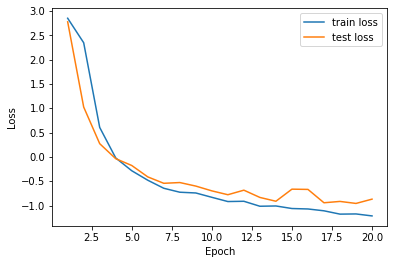

In [40]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, label = 'train loss')
plt.plot(epochs, test_history, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Evaluation

### Posterior plots

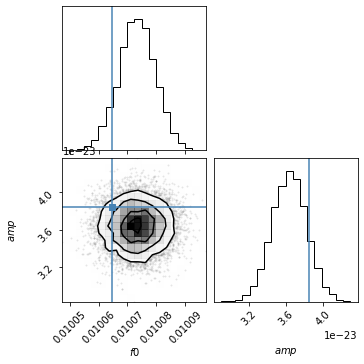

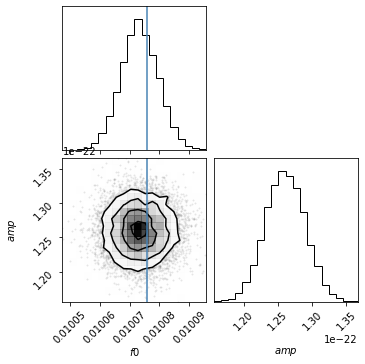

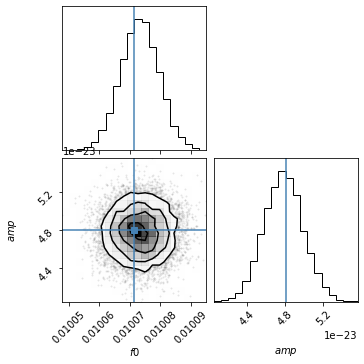

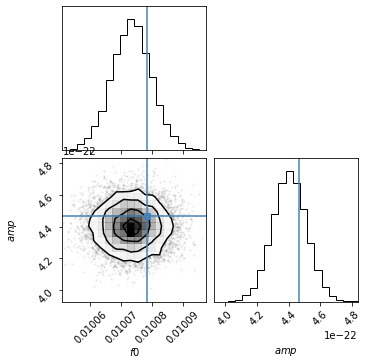

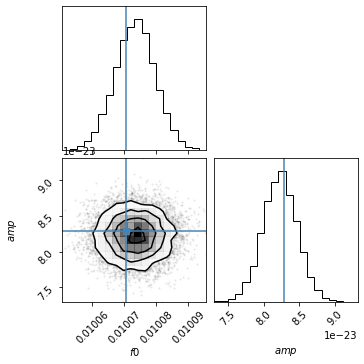

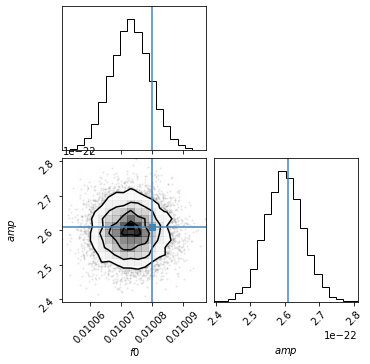

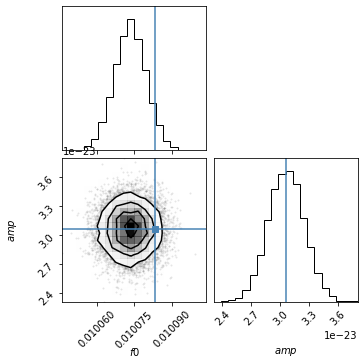

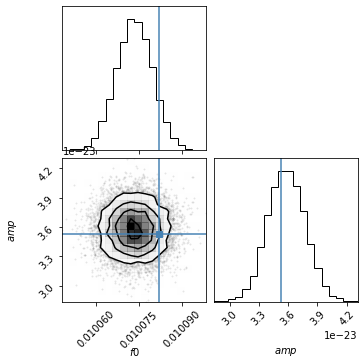

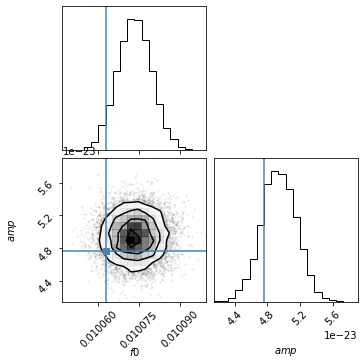

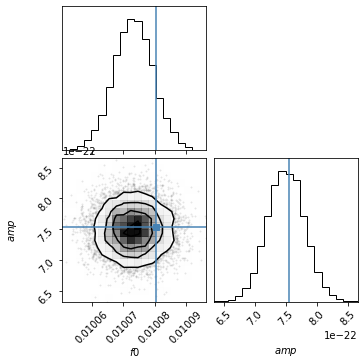

In [41]:
num_posteriors = 10
num_samples = 10000

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    # Predict a posterior
    dist = model(test_x)

    # Sample the posterior
    pred_samples = dist.sample((10000,)).numpy()

    # Undo the standardization
    
    pred_samples = parameters_std * pred_samples + parameters_mean
    truth = parameters_std * test_y.numpy() + parameters_mean

    # Plot
    corner.corner(pred_samples, truths=truth, labels=['$f0$', '$amp$'])
    plt.show()


# @Normalising flow 

We will implement the RealNVP 

https://arxiv.org/abs/1605.08803

It is based on the simple affine transformation, where part of the dimensions are scaled and shifted.

Let's assume that we separate the dimensions into two parts:
$x_{1:d}$ and $x_{d+1:D}$  

Half of the dimensions are kept unchanged:

$y_{1:d} = x_{1:d}$

Other half is transformed with affine transform. Lets define $t$ is a 'shift' function and $s$ is a 'scale' functions. We will parameterise them with neural networks. We apply this transformations to the first part of data:
$s(x_{1:d})$ and $t(x_{1:d})$.

Then we combine it with the data from the second half of dimensions and get:
$y_{d+1:D} = x_{d+1:D} \odot \exp(s(x_{1:d})) + t(x_{1:d})$.

-----------------------------------------------------------------------------


To devide dimensions we use a mask:

In [42]:
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
masks

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])

Trabsformations $s$ and $t$ :

In [43]:
# Define functions s and t as simple fully connected networks:

def t_func(input_dim, hidden_dims, output_dim):
        
    hidden_net_list = []
    hidden_net_list.append(nn.Linear(input_dim, hidden_dims[0]))
    for i in range(1, len(hidden_dims)):
      hidden_net_list.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
      hidden_net_list.append(nn.ReLU())
    hidden_net_list.append(nn.Linear(hidden_dims[i], output_dim))
    
    return nn.Sequential(*hidden_net_list)
 
def s_func(input_dim, hidden_dims, output_dim):
        
    hidden_net_list = []
    hidden_net_list.append(nn.Linear(input_dim, hidden_dims[0]))
    for i in range(1, len(hidden_dims)):
      hidden_net_list.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
      hidden_net_list.append(nn.ReLU())
    hidden_net_list.append(nn.Linear(hidden_dims[i], output_dim))
    hidden_net_list.append(nn.Tanh())

    return nn.Sequential(*hidden_net_list) 
     


In [44]:
input_dim = waveforms.shape[-1] + parameters.shape[-1]
output_dim = parameters.shape[-1]
hidden_dims = [512, 256, 128, 64, 32]

Base distribution is chosen to be Gaussian Multivariate Distribution.



In [45]:

prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Implementation of the flow:

In [46]:
class RealNVP_wf(nn.Module):
    def __init__(self, s_func, t_func, mask, prior):
        super(RealNVP_wf, self).__init__()
        
        self.prior = prior

        self.register_buffer('mask', mask)
        self.t = torch.nn.ModuleList([t_func(input_dim, hidden_dims, output_dim) for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([s_func(input_dim, hidden_dims, output_dim) for _ in range(len(masks))])
        
    def g(self, z, w):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            x_wf = torch.cat([x_, w],dim=1)
            s = self.s[i](x_wf)*(1 - self.mask[i])
            t = self.t[i](x_wf)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x, w):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            z_wf = torch.cat([z_, w],dim=1)
            s = self.s[i](z_wf) * (1-self.mask[i])
            t = self.t[i](z_wf) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    
    def log_prob(self, x, w):
        z, logp = self.f(x, w)
        return self.prior.log_prob(z) + logp
        


In [47]:
flow_wf = RealNVP_wf(s_func, t_func, masks, prior)

In [48]:
# Training and test loops

def train_loop(dataloader, model, optimizer):
 
    size = len(dataloader.dataset)
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        # Compute negative log probability loss

        loss = - model.log_prob(y, X)
    
        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")
            
    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss
            
              
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:

            loss = - model.log_prob(y, X)
            test_loss += loss.sum()

    test_loss /= size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [49]:
optimizer = torch.optim.Adam([p for p in flow_wf.parameters() if p.requires_grad==True], lr=1e-4)

In [50]:
epochs = 20
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, flow_wf, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, flow_wf)
    test_history.append(loss)
print("Done!")

Epoch 1
-------------------------------
Loss: 3.204864  [    0/ 8000 samples]
Loss: 2.954197  [ 3200/ 8000 samples]
Loss: 2.939357  [ 6400/ 8000 samples]
Average loss: 2.8596
Test loss: 2.701393 

Epoch 2
-------------------------------
Loss: 2.671066  [    0/ 8000 samples]
Loss: 2.189056  [ 3200/ 8000 samples]
Loss: 1.143608  [ 6400/ 8000 samples]
Average loss: 1.9062
Test loss: 0.911946 

Epoch 3
-------------------------------
Loss: 0.551335  [    0/ 8000 samples]
Loss: -0.039974  [ 3200/ 8000 samples]
Loss: -0.582710  [ 6400/ 8000 samples]
Average loss: -0.1883
Test loss: -0.260976 

Epoch 4
-------------------------------
Loss: -0.941371  [    0/ 8000 samples]
Loss: -1.276581  [ 3200/ 8000 samples]
Loss: -0.965171  [ 6400/ 8000 samples]
Average loss: -1.0897
Test loss: -0.632005 

Epoch 5
-------------------------------
Loss: -1.559672  [    0/ 8000 samples]
Loss: -1.749857  [ 3200/ 8000 samples]
Loss: -1.717346  [ 6400/ 8000 samples]
Average loss: -1.5596
Test loss: -0.660142 

E

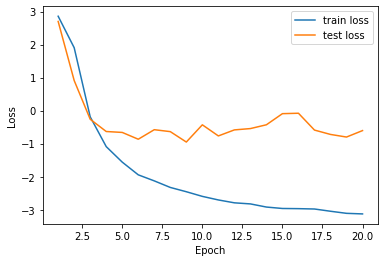

In [51]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, label = 'train loss')
plt.plot(epochs, test_history, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

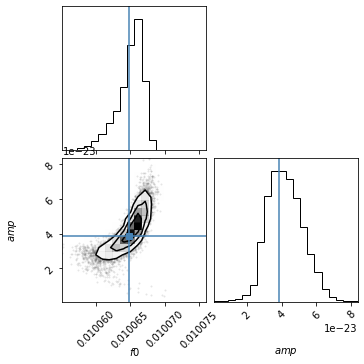

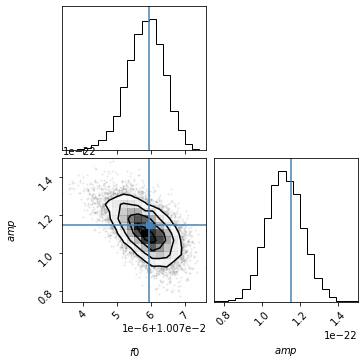

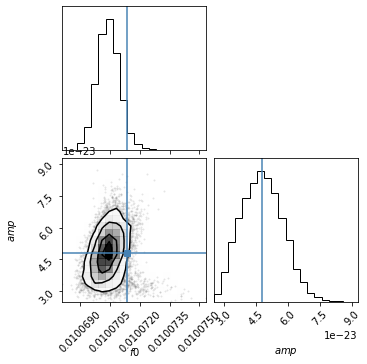

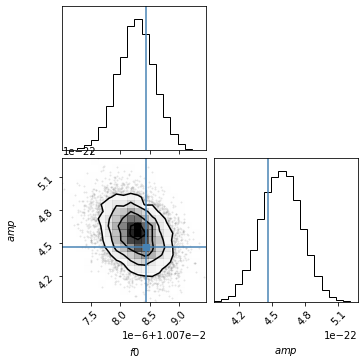

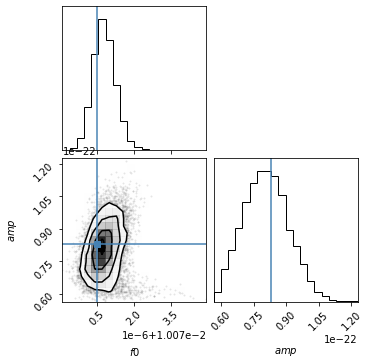

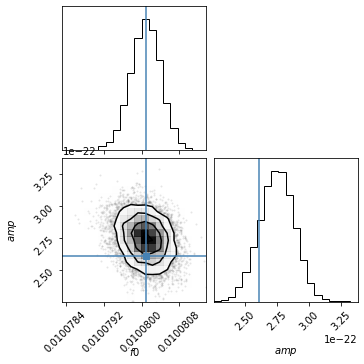

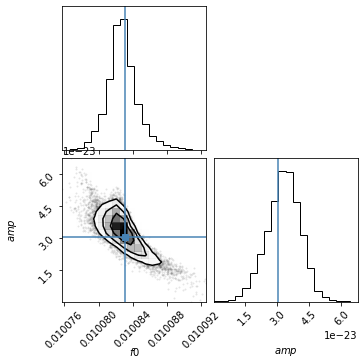

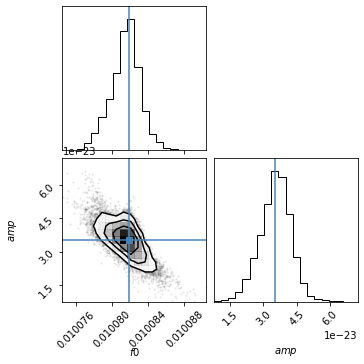

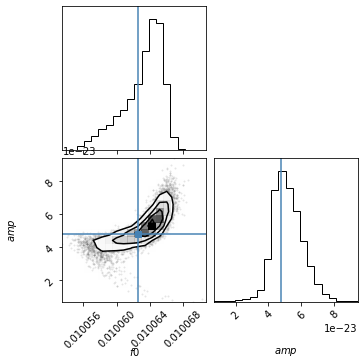

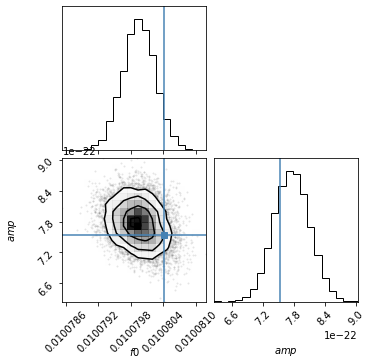

In [52]:
num_posteriors = 10
num_samples = 10000

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    # Repeat same wf for a number of samples
    wf = torch.from_numpy(np.tile(test_x, (num_samples, 1))).type(torch.FloatTensor)

    # Sample from base distribution
    z = prior.sample((num_samples,1)).view(num_samples,-1)

    # Predict a posterior
    pred_samples = flow_wf.g(z, wf).detach().numpy() 

    # Undo the standardization
    pred_samples = parameters_std * pred_samples + parameters_mean
    truth = parameters_std * test_y.numpy() + parameters_mean

    # Plot
    corner.corner(pred_samples, truths=truth, labels=['$f0$', '$amp$'])
    plt.show()